In [1]:
import IPython
from IPython.display import display, HTML, SVG, Image
import graphviz
from graphviz import Source
from io import StringIO
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [10, 6] ## plot size
plt.rcParams['axes.linewidth'] = 2.0 #set the value globally
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_png { display: table-cell; text-align: center; vertical-align: middle; } </style>"))
display(HTML("<style>.MathJax {font-size: 100%;}</style>"))
def set_background(color):
    script = ( "var cell = this.closest('.code_cell');" "var editor = cell.querySelector('.input_area');" "editor.style.background='{}';" "this.parentNode.removeChild(this)" ).format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

import pydotplus
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from sklearn import tree
from sklearn.metrics import * 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
# Feature importance
import shap
import matplotlib.pyplot as plt
# load JS visualization code to notebook
shap.initjs()

In [2]:
#########################
#  Confusion Matrix
#########################
def displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, title):
    # Set font size for the plots. You can ignore this line.
    PLOT_FONT_SIZE = 14
    # Set plot size. Please ignore this line
    plt.rcParams['figure.figsize'] = [5, 5]
    # Transpose of confusion matrix to align the plot with the actual precision recall values. Please ignore this as well.
    confusionMatrix = np.transpose(confusionMatrix)
    # Plotting the confusion matrix
    plt.imshow(confusionMatrix, interpolation='nearest',cmap=plt.cm.Blues, vmin=0, vmax=100)
    
    # Setting plot properties. You should ignore everything from here on.
    xticks = np.array([-0.5, 0, 1,1.5])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(xticks)
    plt.gca().set_xticklabels(["", "Leave\nRecall=" + str(recallNegative) , "Stay\nRecall=" + str(recallPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.gca().set_yticklabels(["", "Leave\nPrecision=" + str(precisionNegative) , "Stay\nPrecision=" + str(precisionPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.ylabel("Predicted Class", fontsize=PLOT_FONT_SIZE)
    plt.xlabel("Actual Class", fontsize=PLOT_FONT_SIZE)
    plt.title(title, fontsize=PLOT_FONT_SIZE)
        
    # Add text in heatmap boxes
    for i in range(2):
        for j in range(2):
            text = plt.text(j, i, confusionMatrix[i][j], ha="center", va="center", color="white", size=15) ### size here is the size of text inside a single box in the heatmap
            
    plt.show()


#########################
# Calc/Print Metrics
#########################
def calculateMetricsAndPrint(predictions, predictionsProbabilities, actualLabels):
    
    # Get probabilities for the class with label 1. That is all we need to compute AUCs. We don't need probabilities for class 0.
    predictionsProbabilities = [item[1] for item in predictionsProbabilities]
    
    # Calculate metrics using scikit-learn functions. The round function is used to round the numbers up to 2 decimal points.
    accuracy = round(accuracy_score(actualLabels, predictions) * 100, 2)
    precisionNegative = round(precision_score(actualLabels, predictions, average = None)[0] * 100, 2)
    precisionPositive = round(precision_score(actualLabels, predictions, average = None)[1] * 100, 2)
    recallNegative = round(recall_score(actualLabels, predictions, average = None)[0] * 100, 2)
    recallPositive = round(recall_score(actualLabels, predictions, average = None)[1] * 100, 2)
    auc = round(roc_auc_score(actualLabels, predictionsProbabilities) * 100, 2)
    confusionMatrix = confusion_matrix(actualLabels, predictions)
    
    # Print metrics. .%2f prints a number upto 2 decimal points only.
    print("Accuracy: %.2f\nPrecisionNegative: %.2f\nPrecisionPositive: %.2f\nRecallNegative: %.2f\nRecallPositive: %.2f\nAUC Score: %.2f\n" % 
          (accuracy, precisionNegative, precisionPositive, recallNegative, recallPositive, auc))
    
    # Display confusion matrix
    displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, "Confusion Matrix")
    
    return auc

#########################
# Feature  Importance
#########################
def showFeatureImportance(classifier, columns):
    columns = columns[:-1]
    print(columns)
    
    # Plot size and font size
    plt.rcParams['figure.figsize'] = [16, 6]
    PLOT_FONT_SIZE = 14
    
    # Get feature importance values
    featureImportance = classifier.feature_importances_
    featureImportanceWithColumns = list(reversed(sorted([[featureImportance[i], columns[i]] for i in range(0, len(columns))])))
    sortedColumns = [item[1] for item in featureImportanceWithColumns]
    sortedFeatures = [item[0] for item in featureImportanceWithColumns]
    
    
    # Plotting
    xaxis = np.arange(len(featureImportance))
    plt.bar(xaxis, sortedFeatures, width = 0.5, color = 'white', hatch = '//', edgecolor = '#8a4191', linewidth = 2.0)
    plt.xticks(xaxis, sortedColumns, fontsize = PLOT_FONT_SIZE, rotation = 45)
    plt.yticks(fontsize = PLOT_FONT_SIZE)
    plt.xlabel("Feature Name",fontsize = PLOT_FONT_SIZE)
    plt.ylabel("Feature Importance",fontsize = PLOT_FONT_SIZE)
    plt.title("Feature Importances", fontsize = PLOT_FONT_SIZE)
    plt.show()
    
    # Table
    importanceDataFrame = pd.DataFrame(featureImportanceWithColumns)
    display(importanceDataFrame)
#################
# From DS1
#################
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))
########
# https://towardsdatascience.com/a-starter-pack-to-exploratory-data-analysis-with-python-pandas-seaborn-and-scikit-learn-a77889485baf
#######
def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)
    plt.show()

########
# https://towardsdatascience.com/a-starter-pack-to-exploratory-data-analysis-with-python-pandas-seaborn-and-scikit-learn-a77889485baf
#######
def quantitative_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=True, swarm=False):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=dataframe,
                      palette=palette, ax=ax)

    plt.show()


In [3]:
# Read data into a data frame
data = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Train.csv", ","))
# Delete null values
data = data.dropna()
# Get column names. We will use these for visualization purposes
columns = list(data.columns)
# Display the data frame as a table
# display(data)

In [4]:

# y = list(data['Department'].unique())
# y.sort()
# print(y)
# print(len(y))
# # data[data['Department']==41]['Department'] = 1
# data_new=data.copy()
# data_new.loc[data['Department'] ==41, 'Department'] = 1
# data_new[data['Department']==41]

# y = list(data_new['Department'].unique())
# y.sort()
# print(y)
# print(len(y))


In [5]:
# Set Dummies
data["HighFlightDep"] = 0

data["HighFlightBrand"] = 0

data["HighFlightChain"] = 0

data["HighFlightGen"] = 0

data["HighFlightTenure"] = 0
# data["LowFlightTenure"] = 0

data["HighFlightManagement"] = 0

# data.loc[data.Department == 37, "LowFlightDep"] =1
# data.loc[data.Department == 40, "LowFlightDep"] =1
# data.loc[data.Department == 38, "LowFlightDep"] =1
# data.loc[data.Department == 19, "LowFlightDep"] =1

# 42              0.857143
# 2               0.819444
# 32              0.740741
# 14              0.666667
# 13              0.619048
# 35              0.606061
# 6               0.605505
# 30              0.602740
# 23              0.601695
# 1               0.600000
# 9               0.590909
# 24              0.586207
# 10              0.584416
# 17              0.576923
# 41              0.571429
# 18              0.571429
# 22              0.568182
# 21              0.551643
# 20              0.546099
# 28              0.546053
data.loc[data.Department == 42, "HighFlightDep"] =1
data.loc[data.Department == 2, "HighFlightDep"] =1
data.loc[data.Department == 32, "HighFlightDep"] =1
data.loc[data.Department == 14, "HighFlightDep"] =1
data.loc[data.Department == 13, "HighFlightDep"] =1
data.loc[data.Department == 35, "HighFlightDep"] =1
data.loc[data.Department == 6, "HighFlightDep"] =1
data.loc[data.Department == 30, "HighFlightDep"] =1
data.loc[data.Department == 23, "HighFlightDep"] =1
data.loc[data.Department == 1, "HighFlightDep"] =1
data.loc[data.Department == 9, "HighFlightDep"] =1
data.loc[data.Department == 24, "HighFlightDep"] =1
data.loc[data.Department == 10, "HighFlightDep"] =1
data.loc[data.Department == 17, "HighFlightDep"] =1
data.loc[data.Department == 41, "HighFlightDep"] =1
data.loc[data.Department == 18, "HighFlightDep"] =1
data.loc[data.Department == 22, "HighFlightDep"] =1
data.loc[data.Department == 21, "HighFlightDep"] =1
data.loc[data.Department == 20, "HighFlightDep"] =1
data.loc[data.Department == 28, "HighFlightDep"] =1


data.loc[data.HotelBrand == 7, "HighFlightBrand"] =1 #.58
data.loc[data.HotelBrand == 2, "HighFlightBrand"] =1 #55%...
data.loc[data.HotelBrand == 3, "HighFlightBrand"] =1 #55%...
data.loc[data.HotelBrand == 4, "HighFlightBrand"] =1 #55%...
data.loc[data.HotelBrand == 6, "HighFlightBrand"] =1 #55%...
data.loc[data.HotelBrand == 1, "HighFlightBrand"] =1 #55%... 

data.loc[data.HotelChainScale == 2, "HighFlightChain"] =1 #.0.549907
data.loc[data.HotelChainScale == 3, "HighFlightChain"] =1 #.0.549907ish
data.loc[data.HotelChainScale == 4, "HighFlightChain"] =1 #.0.549907ish


data.loc[data.Generation == 3, "HighFlightGen"] =1 #.59
data.loc[data.Generation == 2, "HighFlightGen"] =1 #.56

data.loc[data.Tenure == 1, "HighFlightTenure"] =1 #
data.loc[data.Tenure == 8, "HighFlightTenure"] =1 #
data.loc[data.Tenure == 4, "HighFlightTenure"] =1 #
data.loc[data.Tenure == 7, "HighFlightTenure"] =1 #

data.loc[data.ManagementLevel == 3, "HighFlightManagement"] =1 #.71 (only 4%)
data.loc[data.ManagementLevel == 1, "HighFlightManagement"] =1 # .58
data.loc[data.ManagementLevel == 2, "HighFlightManagement"] =1 # .54


# # Moves 'Intent to Stay" back to the end
col = list(data.columns.values)
df= data.pop("IntentToStay")
data['IntentToStay'] = df


In [6]:
data["HighFlightDep"] = data["HighFlightDep"].astype('category')
data["HighFlightBrand"] = data["HighFlightBrand"].astype('category')
data["HighFlightGen"] = data["HighFlightGen"].astype('category')
data["HighFlightTenure"] = data["HighFlightTenure"].astype('category')
data["HighFlightManagement"] = data["HighFlightManagement"].astype('category')
data["HighFlightChain"] = data["HighFlightChain"].astype('category')
data["FullTimePartTime"] = data["FullTimePartTime"].astype('category')


In [57]:
varToInspect = 'HotelChainScale'
num=data.shape[0]
inspect = data[[varToInspect, 'IntentToStay']]
x=inspect.groupby(by=[varToInspect]).mean().sort_values('IntentToStay', ascending=False)
print(x)

print("\n\n% of data:")
print(inspect.groupby(by=[varToInspect]).count()/num)
# df.groupby(by=["B", "C"]).aggregate(pd.np.sum)
num

                 IntentToStay
HotelChainScale              
3                    0.549907
2                    0.547445
4                    0.540705
1                    0.529032
5                    0.416667


% of data:
                 IntentToStay
HotelChainScale              
1                    0.032292
2                    0.114167
3                    0.672083
4                    0.171458
5                    0.010000


4800

In [8]:
# categorical_summarized(data, y = 'IntentToStay', hue='WorkLifeBalance', palette="muted")
# categorical_summarized(data, y = 'IntentToStay', hue='ManagementLevel', palette="muted")
# categorical_summarized(data, y = 'IntentToStay', hue='Department', palette="muted")
# categorical_summarized(data, y = 'IntentToStay', hue='Voice', palette="muted")
# categorical_summarized(data, y = 'IntentToStay', hue='RewardsBenefits', palette="muted")
# categorical_summarized(data, y = 'IntentToStay', hue='Communication', palette="muted")
# categorical_summarized(data, y = 'IntentToStay', hue='LearningDevelopment', palette="muted")
# categorical_summarized(data, y = 'IntentToStay', hue='Generation', palette="muted")
# categorical_summarized(data, y = 'IntentToStay', hue='HotelChainScale', palette="muted")
# categorical_summarized(data, y = 'IntentToStay', hue='HotelBrand', palette="muted")
# sns.countplot(x='HotelChainScale', data=data)
# sns.countplot(x='HotelBrand', data=data)
# sns.countplot(x='Department', data=data)
# sns.countplot(x='Generation', data=data)


In [9]:
columns = list(data.columns)
columns
# df

['AnonymousID',
 'HotelInncode',
 'HotelBrand',
 'HotelChainScale',
 'Generation',
 'Department',
 'FullTimePartTime',
 'Tenure',
 'ManagementLevel',
 'WorkLifeBalance',
 'LearningDevelopment',
 'Communication',
 'Voice',
 'RewardsBenefits',
 'WorkEnvironment',
 'HighFlightDep',
 'HighFlightBrand',
 'HighFlightChain',
 'HighFlightGen',
 'HighFlightTenure',
 'HighFlightManagement',
 'IntentToStay']

In [10]:

corrcols = ['IntentToStay'] + columns[2:-1]
df = data[corrcols]
correlations = df.corr()
# # print (correlations)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(correlations, interpolation='nearest', vmin = -1, vmax = 1)
# # fig.colorbar(cax)
# ticks = np.arange(0, 14, 1)
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(corrcols, rotation=90)
# ax.set_yticklabels(corrcols)
# plt.show()

correlations.style.background_gradient(cmap='coolwarm').set_precision(2)


,IntentToStay,HotelBrand,HotelChainScale,Generation,Department,Tenure,ManagementLevel,WorkLifeBalance,LearningDevelopment,Communication,Voice,RewardsBenefits,WorkEnvironment
IntentToStay,1.00,-0.01,-0.01,0.08,-0.03,0.04,-0.07,0.52,0.53,0.48,0.52,0.54,0.57
HotelBrand,-0.01,1.00,0.58,-0.01,0.10,0.04,-0.01,-0.04,-0.02,-0.02,-0.04,-0.04,-0.01
HotelChainScale,-0.01,0.58,1.00,-0.01,0.05,0.08,-0.00,-0.04,-0.02,-0.05,-0.06,-0.05,-0.05
Generation,0.08,-0.01,-0.01,1.00,0.02,0.46,0.07,0.03,0.02,0.02,0.03,-0.00,-0.02
Department,-0.03,0.10,0.05,0.02,1.00,-0.02,-0.02,-0.00,0.03,0.01,-0.00,0.00,0.02
Tenure,0.04,0.04,0.08,0.46,-0.02,1.00,0.05,-0.00,-0.03,-0.04,-0.03,-0.07,-0.08
ManagementLevel,-0.07,-0.01,-0.00,0.07,-0.02,0.05,1.00,-0.09,-0.13,-0.13,-0.15,-0.12,-0.15
WorkLifeBalance,0.52,-0.04,-0.04,0.03,-0.00,-0.00,-0.09,1.00,0.61,0.52,0.62,0.62,0.66
LearningDevelopment,0.53,-0.02,-0.02,0.02,0.03,-0.03,-0.13,0.61,1.00,0.61,0.73,0.78,0.72
Communication,0.48,-0.02,-0.05,0.02,0.01,-0.04,-0.13,0.52,0.61,1.00,0.61,0.64,0.73


In [11]:
# data.dtypes

In [12]:
###############################
# Old way of dummy vars
###############################

# data_new["Generation"] = data_new["Generation"].astype('category')
# data_new["HotelBrand"] = data_new["HotelBrand"].astype('category')
# data_new["Department"] = data_new["Department"].astype('category')
# # data["HotelChainScale"] = obj_df["Generation"].astype('category')

# depCols = []
# for x in range(1,40):
#     depCols.append('d'+str(x))
# # depCols

# gen = oe_style.fit_transform(data_new[["Generation"]])
# pd.DataFrame(gen.toarray(), columns=['gen1','gen2','gen3']).head()

# brand = oe_style.fit_transform(data_new[["HotelBrand"]])
# pd.DataFrame(brand.toarray(), columns=['B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11']).head()

# Department = oe_style.fit_transform(data_new[["Department"]])
# pd.DataFrame(Department.toarray(), columns=depCols).head()
# data.dtypes


# data_new = data.join(pd.DataFrame(gen.toarray(), columns=['gen1','gen2','gen3']))
# data_new = data_new.join(pd.DataFrame(brand.toarray(), columns=['B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11']))
# data_new = data_new.join(pd.DataFrame(Department.toarray(), columns=depCols))

# # Moves 'Intent to Stay" back to the end
# col = list(data_new.columns.values)
# df= data_new.pop("IntentToStay")
# data_new['IntentToStay'] = df
# # data_new





In [13]:
from sklearn.preprocessing import OneHotEncoder

oe_style = OneHotEncoder()


# Feature and Label Vectors

In [14]:
# columns = list(data_new.columns)
# df = data_new[columns]
# correlations = df.corr()
# print (correlations)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(correlations, interpolation='nearest', vmin = -1, vmax = 1)
# fig.colorbar(cax)
# # ticks = np.arange(0, 14, 1)
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(columns, rotation=90)
# ax.set_yticklabels(columns)
# plt.show()

# correlations.style.background_gradient(cmap='coolwarm').set_precision(2)


# 5.3 Advanced Stuff: XgBoost
XgBoost (Gradient Boosted Trees) is the most widely used machine learning algorithm in the industry these days. It is a powerful algorithm that mixes decision trees, random forests, boosting, and gradients to come up effective classifiers for our data sets. Plenty of kaggle competitions have been won by using this algorithm.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier


# 92.83
dataGB = data_new[['Tenure',  'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment','gen1', 'gen2', 'gen3','d2','d11', 'd36', 'IntentToStay']]
gbClassifier = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, max_features=.8,min_impurity_decrease=.7, n_estimators= 350, subsample= .85, random_state = 1)

In [16]:
print(list(data.columns))

['AnonymousID', 'HotelInncode', 'HotelBrand', 'HotelChainScale', 'Generation', 'Department', 'FullTimePartTime', 'Tenure', 'ManagementLevel', 'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment', 'HighFlightDep', 'HighFlightBrand', 'HighFlightChain', 'HighFlightGen', 'HighFlightTenure', 'HighFlightManagement', 'IntentToStay']


In [64]:
# For GBT and RF
dataGB = data[['Department',  'Tenure',  'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice','Generation', 'RewardsBenefits', 'WorkEnvironment', 'IntentToStay']]


# dataGB = data_new[['Department',  'Tenure',  'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice','Generation', 'RewardsBenefits', 'WorkEnvironment','gen1', 'gen2', 'gen3', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'd22', 'd23', 'd24', 'd25', 'd26', 'd27', 'd28', 'd29', 'd30', 'd31', 'd32', 'd33', 'd34', 'd35', 'd36', 'd37', 'd38', 'd39', 'd40', 'IntentToStay']]


# dataGB = data_new[['Tenure',  'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment','gen1', 'gen2', 'gen3','d2','d11', 'd36', 'IntentToStay']]

# dataGB = data [['WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment', 'HighFlightDep', 'LowFlightDep', 'HighFlightBrand', 'LowFlightBrand', 'LowFlightChain', 'HighFlightGen', 'HighFlightTenure', 'LowFlightTenure', 'HighFlightManagement', 'LowFlightManagement', 'IntentToStay']]


dataGB = data [['FullTimePartTime','ManagementLevel','WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment', 'HighFlightDep', 'HighFlightBrand', 'HighFlightChain', 'HighFlightGen', 'HighFlightTenure', 'HighFlightManagement', 'IntentToStay']]

dataGB = data [['FullTimePartTime','ManagementLevel','WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment', 'HighFlightDep', 'HighFlightBrand',  'HighFlightGen', 'HighFlightTenure', 'IntentToStay']]
dataGB = data [['FullTimePartTime','ManagementLevel','WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment', 'HighFlightDep', 'HighFlightBrand',  'HighFlightGen', 'HighFlightTenure', 'IntentToStay']]

dataGB = data [['FullTimePartTime','ManagementLevel','WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment', 'HighFlightDep', 'HighFlightBrand',  'HighFlightGen', 'HighFlightTenure', 'IntentToStay']]

dataGB


gbCols = list(dataGB.columns)
dataGB = data[list(gbCols)]

print(gbCols)

# For logistic regression and SVMS
xDat = data[['ManagementLevel','WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment', 'HighFlightDep', 'HighFlightBrand',  'HighFlightGen', 'HighFlightTenure']]
lrCols = list(xDat.columns)
yDat = data[['IntentToStay']]

['ManagementLevel', 'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment', 'HighFlightDep', 'HighFlightBrand', 'HighFlightGen', 'HighFlightTenure', 'IntentToStay']


In [68]:
## ## 4.2 Feature and Label Vector
# Convert data to a list of lists1
dataList = dataGB.values.tolist()

# Get features
features = []

# Iterate over each row
for row in dataList:
    
    # Skip the first two columns because they are not needed and the last column because that's the label
    featureValues = row[:-1]

    # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues] 
    
    # Append the features to the feature list
    features.append(featureValues)
    
# Get labels from the data
labels = [row[-1] for row in dataList]

# Label distribution for Leave and Stay respectively
print("Label distribution of 0 and 1", labels.count(0), labels.count(1))

# Test data percentage (0.1 = 10%)
# Note - since the final test set is the blinded Kaggle data, this is essentially a validation set for parameter tuning
TEST_DATA_PERCENTAGE = 0.2

# Split into train and test
trainData, testData, trainLabels, testLabels = train_test_split(features, labels, test_size=TEST_DATA_PERCENTAGE)

Label distribution of 0 and 1 2179 2621


## 5.3.1 Grid Search on XgBoost
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [19]:
set_background('#ffffff')
#####################################################################################################################################################
# Things you can change                                                                                                                             #
#####################################################################################################################################################
# GridSearchCV function takes in a parameter dictionary which is very important here. 
# The dictionary contains as keys the parameter names and values are the possible values of the parameter that you want to test
parameters = {'loss': ["deviance", "exponential"],
            'max_depth': [2,3, 4,5],
            'min_impurity_decrease': [0,.1,.05],
            'learning_rate': [.005,0.1,0.15],
            'n_estimators': [50,100,150,200],
            'max_features':['None',.8,.7,.6],
            'subsample': [.6,.7,.85,1.0]} 
            
parameters = {'max_depth': [3,4],
            'min_impurity_decrease': [0,.1,.05,.5,.7],
            'learning_rate': [.01,0.1,0.15],
            'n_estimators': [80,150,250,350],
            'max_features':['None',.8,],
            'subsample': [.85,1.0]} 

In [20]:
train=True
parameters = {'loss': ["deviance", "exponential"],
            'max_depth': [2,3, 4,5],
            'min_impurity_decrease': [0,.1,.05],
            'learning_rate': [.005,0.1,0.15],
            'n_estimators': [50,100,150,200],
            'max_features':['None',.8,.7,.6],
            'subsample': [.6,.7,.85,1.0]} 

In [21]:
train=False

In [60]:

if (train) :
    gbClassifierWithGridSearch = GridSearchCV(GradientBoostingClassifier(),scoring='roc_auc', cv=5, param_grid=parameters, n_jobs=10, verbose=1)

    # Train the decision tree model using the function .fit
    gbClassifierWithGridSearch.fit(trainData, trainLabels)

    # Calculate training accuracy of the classifier
    # trainAccuracy = gbClassifierWithGridSearch.score(trainData, trainLabels)

    # Predict on test data
    # predictions = gbClassifierWithGridSearch.predict(testData) # This will give binary labels e.g 0/1
    # predictionProbabilities = gbClassifierWithGridSearch.predict_proba(testData) # This will give prediction probabilities for both labels e.g [0.3, 0.7] meaning 0.3 probability for 0 and 0.7 for 1.
    print("Best Parameters are: ", gbClassifierWithGridSearch.best_params_)

In [69]:
# gbClassifier = GradientBoostingClassifier(learning_rate= 0.001, max_depth= 3, max_features=.7,min_impurity_decrease=.7, n_estimators= 350, subsample= .85, random_state = 1)

gbClassifier = GradientBoostingClassifier(learning_rate= 0.1, loss='deviance', max_depth= 2, max_features=.7,min_impurity_decrease=.2, n_estimators= 250, subsample= .9, random_state = 1)
gbClassifier.fit(trainData, trainLabels)
trainAccuracy = gbClassifier.score(trainData, trainLabels)
predictions = gbClassifier.predict(testData) 
predictionProbabilities = gbClassifier.predict_proba(testData) 

Accuracy: 81.15
PrecisionNegative: 77.53
PrecisionPositive: 84.39
RecallNegative: 81.67
RecallPositive: 80.72
AUC Score: 89.16



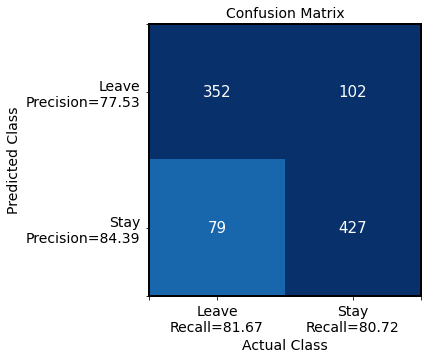

In [70]:
# Calculate metrics on test set and display them
gbtGridAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateGbWithGridSearch, truePositiveRateGbWithGridSearch, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])

# Unfortunately, Feature importance does not work with GridSearch. Instead, we will find the best parameters.


['FullTimePartTime', 'ManagementLevel', 'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment', 'HighFlightDep', 'HighFlightBrand', 'HighFlightGen', 'HighFlightTenure']


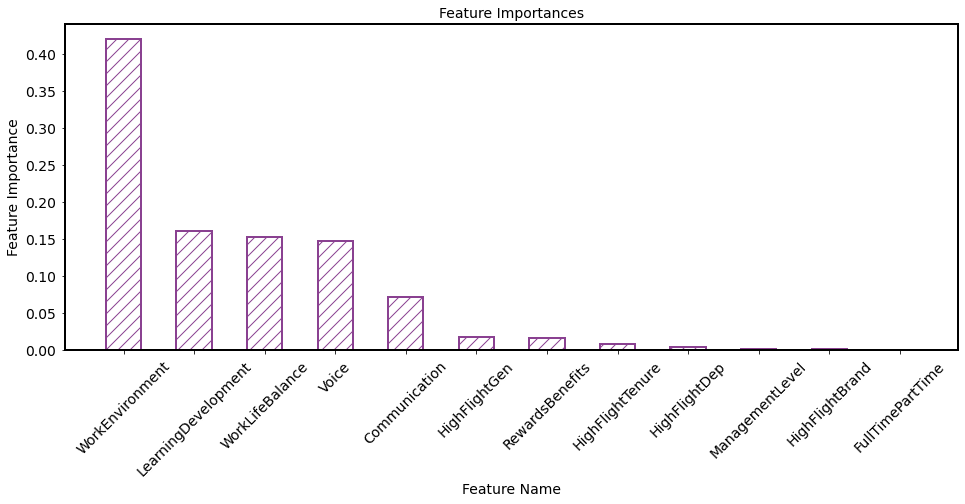

,0,1
0,0.419739,WorkEnvironment
1,0.160766,LearningDevelopment
2,0.152125,WorkLifeBalance
3,0.147163,Voice
4,0.072019,Communication
5,0.016970,HighFlightGen
6,0.016859,RewardsBenefits
7,0.007570,HighFlightTenure
8,0.004596,HighFlightDep
9,0.001147,ManagementLevel


In [63]:
columns=list(dataGB.columns)
showFeatureImportance(gbClassifier, columns)

# Random Forrest

In [26]:
if train :
    parameters = {'n_estimators': [400, 550],
                'max_features': ['auto',.7,.9],
                'min_samples_leaf': [25,50,75],
                'min_impurity_decrease': [0,.3]
                }


    rf_tuned = GridSearchCV(RandomForestClassifier(random_state=201,
                            ccp_alpha=10),param_grid=parameters, cv=4, n_jobs=6, verbose=1)
    rf_tuned.fit(trainData, trainLabels)
    rf_tuned.best_params_

In [27]:
if train:
    rf_tuned.best_params_

Accuracy: 82.29
PrecisionNegative: 79.87
PrecisionPositive: 84.58
RecallNegative: 83.07
RecallPositive: 81.60
AUC Score: 89.62



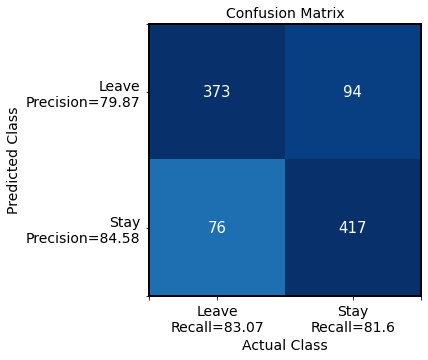

In [28]:

# rfClassifier = RandomForestClassifier(random_state=201, max_features='auto', min_samples_leaf=4, n_estimators=350, ccp_alpha=0) 92 AUC
rfClassifier = RandomForestClassifier(random_state=201, max_features='auto', min_samples_leaf=9, n_estimators=240,min_impurity_decrease=0, ccp_alpha=0)
rfClassifier.fit(trainData, trainLabels)
predictions = rfClassifier.predict(testData)
predictionProbabilities = rfClassifier.predict_proba(testData)

# Calculate metrics on test set and display them
rfAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateRF, truePositiveRateRF, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])
trainAccuracy = gbClassifier.score(trainData, trainLabels)
# Unfortunately, Feature importance does not work with GridSearch. Instead, we will find the best parameters.


['FullTimePartTime', 'ManagementLevel', 'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment', 'HighFlightDep', 'HighFlightBrand', 'HighFlightGen', 'HighFlightTenure']


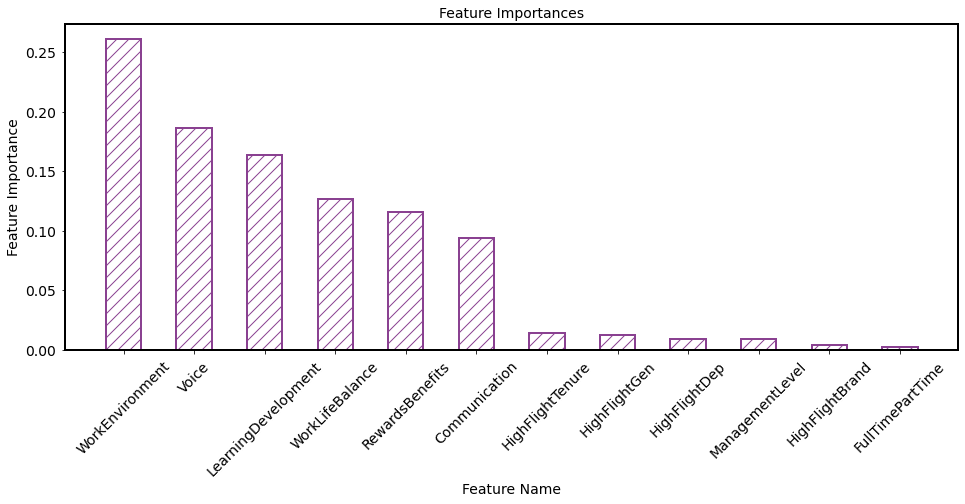

,0,1
0,0.260668,WorkEnvironment
1,0.186526,Voice
2,0.163890,LearningDevelopment
3,0.126652,WorkLifeBalance
4,0.116090,RewardsBenefits
5,0.093906,Communication
6,0.014286,HighFlightTenure
7,0.012282,HighFlightGen
8,0.009569,HighFlightDep
9,0.009334,ManagementLevel


In [29]:
columns=list(dataGB.columns)
showFeatureImportance(rfClassifier, columns)

# Logistic Regression

In [30]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [31]:
# xDat = data[['WorkLifeBalance', 'RewardsBenefits', 'Communication', 'LearningDevelopment', 'Voice', 'WorkEnvironment','ManagementLevel','Generation']]

# xDat = data[['WorkLifeBalance', 'RewardsBenefits', 'Communication', 'LearningDevelopment', 'Voice', 'WorkEnvironment']]
# lrCols = list(xDat.columns)
# yDat = data[['IntentToStay']]

clf = LogisticRegression(solver='liblinear', random_state=0)

x= dict(C = np.logspace(-4, 4, 50), penalty = ['l1', 'l2'])
clfGS = GridSearchCV(clf, cv=5, param_grid=x, verbose=True, n_jobs=6)
clfGS.fit(xDat, yDat)
clfGS.best_estimator_.get_params()

predictions = clfGS.predict(testData)
predictionProbabilities = clfGS.predict_proba(xDat)

clfGS.best_estimator_.get_params()



Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done 446 tasks      | elapsed:   10.4s
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:   12.0s finished


{'C': 0.8286427728546842,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 0,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Accuracy: 81.77
PrecisionNegative: 80.44
PrecisionPositive: 82.94
RecallNegative: 80.62
RecallPositive: 82.78
AUC Score: 88.71



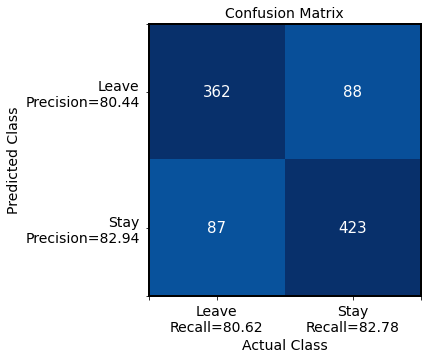

In [32]:
clf = LogisticRegression(solver='liblinear', random_state=0, C=0.8286427728546842, penalty='l1').fit(xDat, yDat)

predictions = clf.predict(testData)
predictionProbabilities = clf.predict_proba(testData)



# Calculate metrics on test set and display them
lrAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateLR, truePositiveRateLR, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])
trainAccuracy = gbClassifier.score(trainData, trainLabels)


# SVC

In [33]:
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV



In [34]:
# clf = LinearSVC()
# model = CalibratedClassifierCV(clf) 
# model.fit(xDat, yDat)


# predictions = model.predict(testData)
# predictionProbabilities = model.predict_proba(testData)

# # # Calculate metrics on test set and display them
# svcAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# # # Calculate FPR and TPR for use in ROC Curve Variance later on
# falsePositiveRateSVC, truePositiveRateSVC, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])


In [35]:
if train:
    param_grid = {'C': [0.5, .1, 1, 5, 10],  
                'gamma': [1, 0.1, 0.01, 0.001, 10], 
                'kernel': ['linear' ]}  
    
    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose=5, n_jobs=8) 
    
    # fitting the model for grid search 
    grid.fit(xDat, yDat) 

    # print best parameter after tuning 
    print(grid.best_params_) 
    
    # print how our model looks after hyper-parameter tuning 
    print(grid.best_estimator_) 


In [36]:
mySVC = SVC(C=1, gamma=.01, kernel='rbf', probability=True)
# mySVC = SVC(C=1, gamma=0.1, kernel='poly', degree=3, probability=True)
mySVC.fit(xDat, yDat) 


SVC(C=1, gamma=0.01, probability=True)

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       449
           1       0.85      0.80      0.83       511

    accuracy                           0.82       960
   macro avg       0.82      0.82      0.82       960
weighted avg       0.82      0.82      0.82       960

Accuracy: 81.98
PrecisionNegative: 78.63
PrecisionPositive: 85.36
RecallNegative: 84.41
RecallPositive: 79.84
AUC Score: 88.52



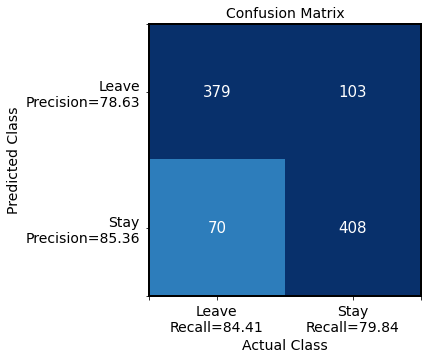

In [37]:
myLinearSVC = SVC(C=0.1, gamma=1, kernel='linear', probability=True)

myLinearSVC.fit(xDat, yDat) 

predictions = myLinearSVC.predict(testData)
print(classification_report(testLabels, predictions)) 
predictionProbabilities = myLinearSVC.predict_proba(testData)

# # Calculate metrics on test set and display them
linearSvcAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# # Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateSVC, truePositiveRateSVC, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])
# columns=list(dataGB.columns)

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       449
           1       0.85      0.79      0.82       511

    accuracy                           0.82       960
   macro avg       0.82      0.82      0.82       960
weighted avg       0.82      0.82      0.82       960

Accuracy: 81.56
PrecisionNegative: 77.87
PrecisionPositive: 85.38
RecallNegative: 84.63
RecallPositive: 78.86
AUC Score: 88.83



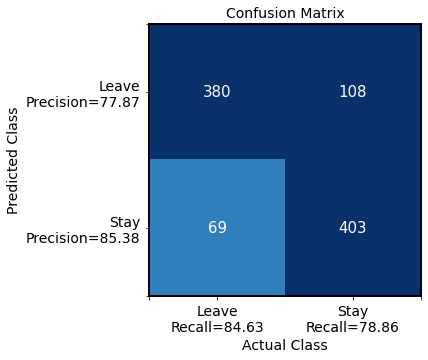

In [38]:

predictions = mySVC.predict(testData)
print(classification_report(testLabels, predictions)) 
predictionProbabilities = mySVC.predict_proba(testData)

# # Calculate metrics on test set and display them
svcAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# # Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateLinearSVC, truePositiveRateLinearSVC, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])

# Results

In [39]:
print("AUC values for different classifiers...")
print("Gradient Boosted Trees: %.3f\nRandom Forrest: %.3f\nLogistic Reg: %.3f\nSVC: %.3f\nLinear SVC: %.3f" % (gbtGridAUC,rfAUC,lrAUC,svcAUC,linearSvcAUC))

AUC values for different classifiers...
Gradient Boosted Trees: 89.610
Random Forrest: 89.620
Logistic Reg: 88.710
SVC: 88.830
Linear SVC: 88.520


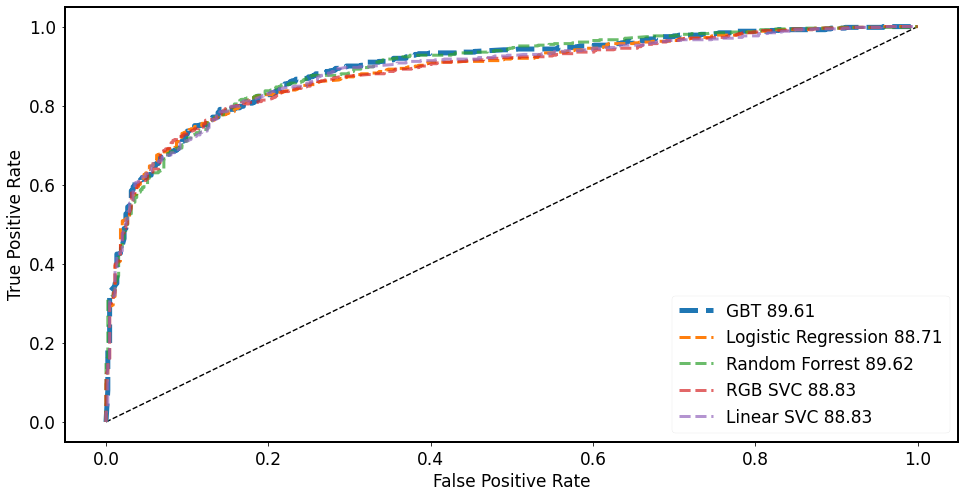

In [40]:
plt.rcParams['figure.figsize'] = [16, 8]
FONT_SIZE = 17

# plt.plot(falsePositiveRateDt, truePositiveRateDt, linewidth = 3, label = "DecisionTree(DT)")
# plt.plot(falsePositiveRateDtWithGridSearch, truePositiveRateDtWithGridSearch, linewidth = 3, label = "DTWithGridSearch")
# plt.plot(falsePositiveRateGb, truePositiveRateGb, linewidth = 3, label = "GradientBoostedTrees(GBT)")
plt.plot([0,1],[0,1], 'k--')
plt.plot(falsePositiveRateGbWithGridSearch, truePositiveRateGbWithGridSearch, linewidth = 5, label = "GBT " + str(gbtGridAUC), linestyle='--')
plt.plot(falsePositiveRateLR, truePositiveRateLR, linewidth = 3, label = "Logistic Regression " + str(lrAUC), linestyle='--')
plt.plot(falsePositiveRateRF, truePositiveRateRF, linewidth = 3, label = "Random Forrest " + str(rfAUC), alpha=.7, linestyle='--')
plt.plot(falsePositiveRateSVC, truePositiveRateSVC, linewidth = 3, label = "RGB SVC " + str(svcAUC), alpha=.7, linestyle='--')
plt.plot(falsePositiveRateLinearSVC, truePositiveRateLinearSVC, linewidth = 3, label = "Linear SVC " + str(svcAUC), alpha=.7, linestyle='--')
plt.legend(fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.xlabel("False Positive Rate", fontsize=FONT_SIZE)
plt.ylabel("True Positive Rate", fontsize=FONT_SIZE)
plt.show()

In [41]:
# return the indicies from the original dataframe that we used as features in our model
def findIndiciesOfFeatures(features, original):
    indicies = []
    originalCols = list(original.columns)
    for feature in features :
        if feature in originalCols:
            # print(feature)
            # print (originalCols.index(feature))
            indicies.append(originalCols.index(feature))
    if(indicies[-1] == 21):
        indicies.pop()
    return indicies

# Test above function..
# print(np.array_equal(np.asarray(data.columns)[findIndiciesOfFeatures(dtCols,data)], dtCols[:-1]))
print(np.array_equal(np.asarray(data.columns)[findIndiciesOfFeatures(gbCols,data)], gbCols[:-1]))
# print(np.array_equal(np.asarray(data.columns)[findIndiciesOfFeatures(lrCols,data)], lrCols))



True


In [42]:
print(findIndiciesOfFeatures(gbCols,data))
# print(data_new.iloc[findIndiciesOfFeatures(gbCols,data_new)])
data.columns[findIndiciesOfFeatures(gbCols,data)]

[6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19]


Index(['FullTimePartTime', 'ManagementLevel', 'WorkLifeBalance',
       'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits',
       'WorkEnvironment', 'HighFlightDep', 'HighFlightBrand', 'HighFlightGen',
       'HighFlightTenure'],
      dtype='object')

In [43]:
#######################
# Old dummy method
#######################
# gen = oe_style.fit_transform(testDataForSubmission[["Generation"]])
# pd.DataFrame(gen.toarray(), columns=['gen1','gen2','gen3']).head()

# brand = oe_style.fit_transform(testDataForSubmission[["HotelBrand"]])
# pd.DataFrame(brand.toarray(), columns=['B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11']).head()

# Department = oe_style.fit_transform(testDataForSubmission[["Department"]])
# pd.DataFrame(Department.toarray(), columns=depCols).head()


# testDataForSubmission = testDataForSubmission.join(pd.DataFrame(gen.toarray(), columns=['gen1','gen2','gen3']))
# testDataForSubmission = testDataForSubmission.join(pd.DataFrame(brand.toarray(), columns=['B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11']))
# testDataForSubmission = testDataForSubmission.join(pd.DataFrame(Department.toarray(), columns=depCols))
# testDataListForSubmission = testDataForSubmission.values.tolist()


In [44]:
# Read data into a data frame
testDataForSubmission = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Test.csv", ","))
# Delete null values
testDataForSubmission = testDataForSubmission.dropna()
# Convert data to a list of lists


In [45]:
# Set Dummies
testDataForSubmission["HighFlightDep"] = 0
testDataForSubmission["HighFlightBrand"] = 0
testDataForSubmission["HighFlightChain"] = 0
testDataForSubmission["HighFlightGen"] = 0
testDataForSubmission["HighFlightTenure"] = 0
testDataForSubmission["HighFlightManagement"] = 0
testDataForSubmission.loc[testDataForSubmission.Department == 42, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 2, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 32, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 14, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 13, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 35, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 6, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 30, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 23, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 1, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 9, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 24, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 10, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 17, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 41, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 18, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 22, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 21, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 20, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.Department == 28, "HighFlightDep"] =1
testDataForSubmission.loc[testDataForSubmission.HotelBrand == 7, "HighFlightBrand"] =1 #.58
testDataForSubmission.loc[testDataForSubmission.HotelBrand == 2, "HighFlightBrand"] =1 #55%...
testDataForSubmission.loc[testDataForSubmission.HotelBrand == 3, "HighFlightBrand"] =1 #55%...
testDataForSubmission.loc[testDataForSubmission.HotelBrand == 4, "HighFlightBrand"] =1 #55%...
testDataForSubmission.loc[testDataForSubmission.HotelBrand == 6, "HighFlightBrand"] =1 #55%...
testDataForSubmission.loc[testDataForSubmission.HotelBrand == 1, "HighFlightBrand"] =1 #55%... 
testDataForSubmission.loc[testDataForSubmission.HotelChainScale == 2, "HighFlightChain"] =1 #.416
testDataForSubmission.loc[testDataForSubmission.HotelChainScale == 3, "HighFlightChain"] =1 #.416
testDataForSubmission.loc[testDataForSubmission.HotelChainScale == 4, "HighFlightChain"] =1 #.416
testDataForSubmission.loc[testDataForSubmission.Generation == 3, "HighFlightGen"] =1 #.59
testDataForSubmission.loc[testDataForSubmission.Generation == 2, "HighFlightGen"] =1 #.56
testDataForSubmission.loc[testDataForSubmission.Tenure == 1, "HighFlightTenure"] =1 #
testDataForSubmission.loc[testDataForSubmission.Tenure == 8, "HighFlightTenure"] =1 #
testDataForSubmission.loc[testDataForSubmission.Tenure == 4, "HighFlightTenure"] =1 #
testDataForSubmission.loc[testDataForSubmission.Tenure == 7, "HighFlightTenure"] =1 #
testDataForSubmission.loc[testDataForSubmission.ManagementLevel == 3, "HighFlightManagement"] =1 #.71 (only 4%)
testDataForSubmission.loc[testDataForSubmission.ManagementLevel == 1, "HighFlightManagement"] =1 # .58
testDataForSubmission.loc[testDataForSubmission.ManagementLevel == 2, "HighFlightManagement"] =1 # .54
testDataListForSubmission = testDataForSubmission.values.tolist()


In [46]:
testDataForSubmission.shape

(1264, 21)

In [47]:
data.shape


(4800, 22)

In [48]:
testDataForSubmission.columns

Index(['AnonymousID', 'HotelInncode', 'HotelBrand', 'HotelChainScale',
       'Generation', 'Department', 'FullTimePartTime', 'Tenure',
       'ManagementLevel', 'WorkLifeBalance', 'LearningDevelopment',
       'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment',
       'HighFlightDep', 'HighFlightBrand', 'HighFlightChain', 'HighFlightGen',
       'HighFlightTenure', 'HighFlightManagement'],
      dtype='object')

In [49]:
data.columns

Index(['AnonymousID', 'HotelInncode', 'HotelBrand', 'HotelChainScale',
       'Generation', 'Department', 'FullTimePartTime', 'Tenure',
       'ManagementLevel', 'WorkLifeBalance', 'LearningDevelopment',
       'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment',
       'HighFlightDep', 'HighFlightBrand', 'HighFlightChain', 'HighFlightGen',
       'HighFlightTenure', 'HighFlightManagement', 'IntentToStay'],
      dtype='object')

In [50]:
findIndiciesOfFeatures(gbCols,data)

[6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19]

In [51]:
# # Read data into a data frame
# testDataForSubmission = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Test.csv", ","))
# # Delete null values
# testDataForSubmission = testDataForSubmission.dropna()
# # Convert data to a list of lists
# testDataListForSubmission = testDataForSubmission.values.tolist()
# Get features
testFeaturesForSubmissionDT = []
testFeaturesForSubmissionGB = []
testFeaturesForSubmissionLR = []
# Decision Tree
# indicies = findIndiciesOfFeatures(dtCols,data)
# for row in testDataListForSubmission:
#     # Skip the first two columns because they are not needed and the last column because that's the label
#     nprow = np.asarray(row)
#     # featureValues = nprow[[9,10,11,12,13,14]]
#     featureValues = nprow[[indicies]]
#     # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
#     featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues]  
#     # Append the features to the feature list
#     testFeaturesForSubmissionDT.append(featureValues)

indicies = findIndiciesOfFeatures(gbCols,data)
for row in testDataListForSubmission:
    nprow = np.asarray(row)
    featureValues = nprow[[indicies]]
    # print(featureValues)
    # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues]  
    # Append the features to the feature list
    testFeaturesForSubmissionGB.append(featureValues)


indicies = findIndiciesOfFeatures(lrCols,data)
for row in testDataListForSubmission:
    nprow = np.asarray(row)
    featureValues = nprow[[indicies]]
    # print(featureValues)
    # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues]  
    # Append the features to the feature list
    testFeaturesForSubmissionLR.append(featureValues)

In [52]:
# nprow = np.asarray([35422.0, 100223.0, 6.0, 3.0, 1.0, 5.0, 0.0, 7.0, 4.0, 4.0, 2.0, 1.0, 1.0, 2.5, 4.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0])
# nprow[[indicies]]

In [53]:
# testFeaturesForSubmissionGB
# gbCols

In [54]:
# resultsFile = open("Results/rf.csv", "w")
# resultsFile.write("Id,Expected\n")
# for rfPredictionProb, i in zip(rfClassifier.predict_proba(testFeaturesForSubmissionGB), np.arange(len(testFeaturesForSubmissionGB))):
#     resultsFile.write(str(i + 1) + "," + str(rfPredictionProb[1]) + "\n")
# resultsFile.close()

resultsFile = open("Results/gbt.csv", "w")
resultsFile.write("Id,Expected\n")
for gbPredictionProb, i in zip(gbClassifier.predict_proba(testFeaturesForSubmissionGB), np.arange(len(testFeaturesForSubmissionGB))):
    resultsFile.write(str(i + 1) + "," + str(gbPredictionProb[1]) + "\n")
resultsFile.close()

resultsFile = open("Results/rf.csv", "w")
resultsFile.write("Id,Expected\n")
for rfPredictionProb, i in zip(rfClassifier.predict_proba(testFeaturesForSubmissionGB), np.arange(len(testFeaturesForSubmissionGB))):
    resultsFile.write(str(i + 1) + "," + str(rfPredictionProb[1]) + "\n")
resultsFile.close()

In [55]:
resultsFile = open("Results/lr.csv", "w")
resultsFile.write("Id,Expected\n")
for clfPredictionProb, i in zip(clf.predict_proba(testFeaturesForSubmissionLR), np.arange(len(testFeaturesForSubmissionLR))):
    resultsFile.write(str(i + 1) + "," + str(float(gbPredictionProb[1])) + "\n")
resultsFile.close()

resultsFile = open("Results/svc.csv", "w")
resultsFile.write("Id,Expected\n")
for svcPredictionProb, i in zip(myLinearSVC.predict_proba(testFeaturesForSubmissionLR), np.arange(len(testFeaturesForSubmissionLR))):
    resultsFile.write(str(i + 1) + "," + str(float(gbPredictionProb[1])) + "\n")
resultsFile.close()

In [56]:
# resultsFile = open("Results/gb_lr.csv", "w")
# resultsFile.write("Id,Expected\n")
# for clfPredictionProb,gbPredictionProb, i in zip(clf.predict_proba(testFeaturesForSubmissionLR),gbClassifier.predict_proba(testFeaturesForSubmissionGB), np.arange(len(testFeaturesForSubmissionGB))):
#     resultsFile.write(str(i + 1) + "," + str((float(gbPredictionProb[1])+float(clfPredictionProb[1]))/2) + "\n")
# resultsFile.close()


# resultsFile = open("Results/gb_lr_rf.csv", "w")
# resultsFile.write("Id,Expected\n")
# for rfPredictionProb,clfPredictionProb,gbPredictionProb, i in zip(rfClassifier.predict_proba(testFeaturesForSubmissionGB),clf.predict_proba(testFeaturesForSubmissionLR),gbClassifier.predict_proba(testFeaturesForSubmissionGB), np.arange(len(testFeaturesForSubmissionGB))):
#     resultsFile.write(str(i + 1) + "," + str((float(rfPredictionProb[1])+float(clfPredictionProb[1])+float(gbPredictionProb[1]))/3) + "\n")
# resultsFile.close()

resultsFile = open("Results/gb_rf.csv", "w")
resultsFile.write("Id,Expected\n")
for rfPredictionProb,gbPredictionProb, i in zip(rfClassifier.predict_proba(testFeaturesForSubmissionGB),gbClassifier.predict_proba(testFeaturesForSubmissionGB), np.arange(len(testFeaturesForSubmissionGB))):
    resultsFile.write(str(i + 1) + "," + str((float(rfPredictionProb[1])+float(gbPredictionProb[1]))/2) + "\n")
resultsFile.close()
    
print("All predictions have been placed in the results folder...")

All predictions have been placed in the results folder...
